<h2>Imports</h2>

In [12]:
# All the imports

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import types
from botocore.client import Config
import ibm_boto3

import json

import requests
from pandas.io.json import json_normalize

import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

!pip install folium==0.5.0
import folium 

<h2>Montreal Raw Data</h2>

In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
body = client_ad8a395b1a824e92be16f752eb12ce20.get_object(Bucket='capstone-donotdelete-pr-tbdvkbr5if4f3p',Key='quartierreferencehabitation.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)
mount = df_data_3.drop(columns=['no_qr', 'nom_mun','no_arr'])

In [15]:

body = client_ad8a395b1a824e92be16f752eb12ce20.get_object(Bucket='capstone-donotdelete-pr-tbdvkbr5if4f3p',Key='Neighbourhoods.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_5 = pd.read_csv(body)
df_data_5.head()


,Neighbourhood,Latitude,Longitude
0,Rivière-des-Prairies,45.6677,-73.5462
1,Beaurivage,45.5982,-73.5139
2,Tétreaultville,45.6018,-73.5246
3,Dupéré,45.6046,-73.5357
4,Guybourg,45.5742,-73.5206


Time to merge!

In [16]:
# Combine the two data sets
city = mount.merge(df_data_5, how='inner', on='Neighbourhood')

#find one Borough
riv_data = city[city['Borough'] == 'Mercier–Hochelaga-Maisonneuve'].reset_index(drop=True)
riv_data.head()

,Neighbourhood,Borough,Latitude,Longitude
0,Beaurivage,Mercier–Hochelaga-Maisonneuve,45.5982,-73.5139
1,Tétreaultville,Mercier–Hochelaga-Maisonneuve,45.6018,-73.5246
2,Dupéré,Mercier–Hochelaga-Maisonneuve,45.6046,-73.5357
3,Guybourg,Mercier–Hochelaga-Maisonneuve,45.5742,-73.5206
4,Longue-Pointe,Mercier–Hochelaga-Maisonneuve,45.5781,-73.5382


In [17]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(riv_data['Borough'].unique()),
        riv_data.shape[0]
    )
)

The dataframe has 1 boroughs and 9 neighbourhoods.


In [18]:
address = 'Mercier–Hochelaga-Maisonneuve, QC' 

geolocator = Nominatim(user_agent="qb_explorer")
location = geolocator.geocode(address)
nlatitude = location.latitude
nlongitude = location.longitude
print('The geograpical coordinate of Mercier–Hochelaga-Maisonneuve, Montreal are {}, {}.'.format(nlatitude, nlongitude))

The geograpical coordinate of Mercier–Hochelaga-Maisonneuve, Montreal are 45.574098500000005, -73.52583797301901.


In [19]:
# create map of Quebec City using latitude and longitude values
map_quebec = folium.Map(location=[nlatitude, nlongitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(riv_data['Latitude'], city['Longitude'], city['Borough'], city['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_quebec)  
    
map_quebec

<h2>Using FourSquare API</h2>

<h3>Getting Venues</h3>

In [20]:
# Foursqaure ID

import json
{
    "tags": [
        "remove-input",
    ]
}
CLIENT_ID = '4F2TWL40HEUEKJXU01ZUMRE4ZNYOGGTRNMPLGRVNJT33J1KJ' # your Foursquare ID
CLIENT_SECRET = 'O5MCRNOS2HOODSSYWX15PYEVB05WZMPY2VGB3GC1K4KQBCFG' # your Foursquare Secret
ACCESS_TOKEN = 'KFUMX2PWRS3FVCUZRGFCYPKLJ1VEKWDLC2NWLHOW24M3S5C4'
version = '20180605' # Foursquare API version
limit = 100 # A default Foursquare API limit value
radius = 2000 

In [21]:
#function created to find the venues dealing only with food

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        categoryId = '4d4b7105d754a06374d81259' # ID of 'Food'
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']

        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'],
            v['id'],
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                    'Venue Id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
#run function for food venues

city_venues = getNearbyVenues(names=riv_data['Neighbourhood'],
                                   latitudes=riv_data['Latitude'],
                                   longitudes=riv_data['Longitude']
                                  )

Beaurivage
Tétreaultville
Dupéré
Guybourg
Longue-Pointe
Louis-Riel
Maisonneuve
Hochelaga
Préfontaine


In [23]:
#cleaning up the data duplicates
cityven = city_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'], keep='last')
cityven.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Beaurivage,45.5982,-73.5139,Coronel Restaurant,4c06740b708395211e357bce,45.599833,-73.512395,Diner
10,Beaurivage,45.5982,-73.5139,St-Hubert Express,5716456a498e9bb9e88d52e7,45.595665,-73.534821,Restaurant
18,Beaurivage,45.5982,-73.5139,La Cage aux Sports,4cc84b4bcaa5a1cd27b49ce7,45.590539,-73.539238,Gastropub
22,Beaurivage,45.5982,-73.5139,L'express Asiatique,509d8cace4b0fe0aa4bdcc28,45.604393,-73.530472,Asian Restaurant
23,Beaurivage,45.5982,-73.5139,Kaido Resto,5011bcc8e4b088cc6b418130,45.610929,-73.533703,Asian Restaurant


In [24]:
print('There are {} uniques categories.'.format(len(cityven['Venue Category'].unique())))

There are 48 uniques categories.


<h3> Getting Ratings </h3>

In [25]:
# function for likes of specific venues

def getVenueRatings(venueId):
    
    venues_list=[]

    for venueId in venueId:
        print(venueId)
    
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
            venueId, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            version, 
           )    
    
        results = requests.get(url).json()['response']
        venues_list.append((venueId,
            results['likes']['count']))

    near_venues = pd.DataFrame(venues_list, columns =['Venue Id', 'Venue Likes']) 

    return(near_venues)

In [26]:
# run likes function

venuelist = getVenueRatings(venueId=cityven['Venue Id'])

4c06740b708395211e357bce
5716456a498e9bb9e88d52e7
4cc84b4bcaa5a1cd27b49ce7
509d8cace4b0fe0aa4bdcc28
5011bcc8e4b088cc6b418130
4f97f86be4b0cb04ce38115a
4aeb1f66f964a520a9be21e3
4fdbcc6ce4b0659232e24fe6
530cd3bf498e0a767e83a4cc
4ba4d06af964a5206cb738e3
592a13793b4e0068ec2d7d05
4b6b69faf964a52026072ce3
531b80a6498ed935082f1400
4b6cc08af964a520b8512ce3
4d3c5327d2c8f04d76996072
5064c0bbe4b01053556736b8
4dd861d9d1647fcf3e633903
55198a64498eed3a6b5f866f
4c05a04b5753c92800c939f1
4b70c873f964a520792e2de3
5e111391ea67c90007200ced
5ead8bf975c97d000822e644
4b97d532f964a520b71835e3
4c0fe01bce640f4781073952
4c9a2c4478fc236a7b2b3397
4b3fd7d8f964a5204fb025e3
4bfec778e584c9289c396d25
4c27711cc11dc9b61f8a2a24
4bd0822c9854d13a06d6f74d
500c66c4e4b0e68938ae0c5f
4eab43a161af01ea2aba30ce
4e2b9cd281dce8c49d1061e9
4c7ef03e171b224b80800fb1
4cb21017aef16dcb4a78be54
4fdbf22fe4b0598b206fcf18
5d4d7d877d032b0007829044
4e5fad4ca809fd281937eb43
4dfaba4fb61c6408772d35da
4c3903762c8020a118f88b00
52f41d1c498e9539f0f736ac


In [27]:
#making sure it has collected the right data

venuelist.head()

,Venue Id,Venue Likes
0,4c06740b708395211e357bce,9
1,5716456a498e9bb9e88d52e7,1
2,4cc84b4bcaa5a1cd27b49ce7,27
3,509d8cace4b0fe0aa4bdcc28,0
4,5011bcc8e4b088cc6b418130,0


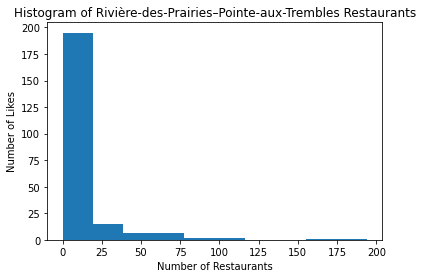

In [60]:
#showing the frequency of the likes

venuelist['Venue Likes'].plot(kind='hist')

plt.title('Histogram of Rivière-des-Prairies–Pointe-aux-Trembles Restaurants') # add a title to the histogram
plt.ylabel('Number of Likes') # add y-label
plt.xlabel('Number of Restaurants') # add x-label

plt.show()

In [79]:
# assigning Categories to the Likes

Poor = venuelist['Venue Likes']<=(np.percentile(venuelist['Venue Likes'], 25))
Acceptable = venuelist[(venuelist['Venue Likes']>(np.percentile(venuelist['Venue Likes'], 25))) & (venuelist['Venue Likes']<=(np.percentile(venuelist['Venue Likes'], 50)))]
Good = venuelist[(venuelist['Venue Likes']>(np.percentile(venuelist['Venue Likes'], 50))) & (venuelist['Venue Likes']<=(np.percentile(venuelist['Venue Likes'], 75)))]
Great = venuelist[(venuelist['Venue Likes']>(np.percentile(venuelist['Venue Likes'], 75))) & (venuelist['Venue Likes']<=(np.percentile(venuelist['Venue Likes'], 90)))]
Excellent = venuelist['Venue Likes']>(np.percentile(venuelist['Venue Likes'], 90))


def conditions(l):
    if l['Venue Likes']<=(np.percentile(venuelist['Venue Likes'], 25)):
        return 'Poor'
    if l['Venue Likes']<=(np.percentile(venuelist['Venue Likes'], 50)):
        return 'Acceptable'
    if l['Venue Likes']<=(np.percentile(venuelist['Venue Likes'], 75)):
        return 'Good'
    if l['Venue Likes']<=(np.percentile(venuelist['Venue Likes'], 90)):
        return 'Great'
    if l['Venue Likes']>(np.percentile(venuelist['Venue Likes'], 90)):
        return 'Excellent'

venuelist['Likes Categories']=venuelist.apply(conditions, axis=1)

In [80]:
# showing the neighbourhoods, venues and the venue's likes.

venuelike= venuelist.merge(cityven, how='inner', on='Venue Id')
venlike= venuelike.drop(['Neighbourhood Latitude','Neighbourhood Longitude'], axis=1)
venlike.head()

,Venue Id,Venue Likes,Likes Categories,Neighbourhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4c06740b708395211e357bce,9,Good,Beaurivage,Coronel Restaurant,45.599833,-73.512395,Diner
1,5716456a498e9bb9e88d52e7,1,Acceptable,Beaurivage,St-Hubert Express,45.595665,-73.534821,Restaurant
2,4cc84b4bcaa5a1cd27b49ce7,27,Great,Beaurivage,La Cage aux Sports,45.590539,-73.539238,Gastropub
3,509d8cace4b0fe0aa4bdcc28,0,Poor,Beaurivage,L'express Asiatique,45.604393,-73.530472,Asian Restaurant
4,5011bcc8e4b088cc6b418130,0,Poor,Beaurivage,Kaido Resto,45.610929,-73.533703,Asian Restaurant


<h2> One SHot this data! </h2> <h3>1s and 0s only</h3>

In [81]:
# one hot encoding
city_oneshot = pd.get_dummies(venlike[['Likes Categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_oneshot['Venue Id'] = venlike['Venue Id'] 

# move neighborhood column to the first column
fixed_columns = [city_oneshot.columns[-1]] + list(city_oneshot.columns[:-1])
city_oneshot = city_oneshot[fixed_columns]

city_oneshot.head()

,Venue Id,Acceptable,Excellent,Good,Great,Poor
0,4c06740b708395211e357bce,0,0,1,0,0
1,5716456a498e9bb9e88d52e7,1,0,0,0,0
2,4cc84b4bcaa5a1cd27b49ce7,0,0,0,1,0
3,509d8cace4b0fe0aa4bdcc28,0,0,0,0,1
4,5011bcc8e4b088cc6b418130,0,0,0,0,1


In [82]:
# Order them in frecency of Id

city_grouped = city_oneshot.groupby('Venue Id').mean().reset_index()
city_grouped.head()

,Venue Id,Acceptable,Excellent,Good,Great,Poor
0,4adb3fd3f964a520352521e3,0,1,0,0,0
1,4adb99a5f964a5204a2921e3,0,0,1,0,0
2,4adc86a6f964a520e72c21e3,1,0,0,0,0
3,4adcce7ff964a520023021e3,1,0,0,0,0
4,4addf975f964a520f26621e3,0,0,0,0,1


<h2>Make a cluster map!</h2>

In [83]:
kclusters = 5

city_grouped_clustering = city_grouped.drop('Venue Id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 2, 1, 1, 0, 2, 1, 3, 4, 4], dtype=int32)

In [84]:
# add clustering labels
city_grouped.insert(1, 'Cluster Labels', kmeans.labels_)

# merge tables to add latitude/longitude for each neighborhood
city_merge = city_grouped.merge(venlike, on='Venue Id')

In [85]:
# create map
latitude = nlatitude
longitude = nlongitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merge['Venue Latitude'], city_merge['Venue Longitude'], city_merge['Neighbourhood'], city_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [86]:
# Cluster 0: "Poor" Rating 

poor = city_merge.loc[city_merge['Cluster Labels'] == 0, city_merge.columns[[0] + list(range(6, city_merge.shape[1]))]]
poor.head()

,Venue Id,Poor,Venue Likes,Likes Categories,Neighbourhood,Venue,Venue Latitude,Venue Longitude,Venue Category
4,4addf975f964a520f26621e3,1,0,Poor,Louis-Riel,Villa Madina,45.589869,-73.539313,Restaurant
18,4b1e8945f964a520381b24e3,1,0,Poor,Longue-Pointe,Place Tevere,45.591712,-73.541321,Italian Restaurant
32,4b6b69faf964a52026072ce3,1,0,Poor,Tétreaultville,Thai Express,45.589869,-73.539313,Restaurant
36,4b7402fdf964a520b9c32de3,1,0,Poor,Préfontaine,Dunkin',45.532661,-73.574462,Donut Shop
47,4bb3e410f187a5938e9813f8,1,0,Poor,Guybourg,Arahova,45.574249,-73.548107,Greek Restaurant


In [95]:
# Cluster 1: "Excellent" Rating

excellent = city_merge.loc[city_merge['Cluster Labels'] == 4, city_merge.columns[[0] + list(range(6, city_merge.shape[1]))]]
excellent.head()

,Venue Id,Poor,Venue Likes,Likes Categories,Neighbourhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4adb3fd3f964a520352521e3,0,79,Excellent,Préfontaine,Café Lézard,45.549485,-73.574137,Diner
8,4af7fc8cf964a520aa0a22e3,0,99,Excellent,Préfontaine,La Maison du Rôti,45.534408,-73.573187,Butcher
9,4b0b7093f964a520803123e3,0,40,Excellent,Préfontaine,Première Moisson,45.548738,-73.574489,Bakery
11,4b0d4a48f964a520b94523e3,0,194,Excellent,Louis-Riel,Galeries d'Anjou,45.600796,-73.564669,Shopping Mall
12,4b116803f964a520eb7b23e3,0,28,Excellent,Préfontaine,L'Œufrier,45.534719,-73.572918,Breakfast Spot


In [93]:
# Cluster 2: "Great" Rating

great = city_merge.loc[city_merge['Cluster Labels'] == 3, city_merge.columns[[0] + list(range(6, city_merge.shape[1]))]]
great.head()

,Venue Id,Poor,Venue Likes,Likes Categories,Neighbourhood,Venue,Venue Latitude,Venue Longitude,Venue Category
7,4aeb5b89f964a5205cc121e3,0,20,Great,Préfontaine,Maison des cyclistes,45.527064,-73.573065,Café
10,4b0b70e7f964a520843123e3,0,23,Great,Préfontaine,Première Moisson,45.553994,-73.539321,Bakery
13,4b141158f964a520bb9c23e3,0,27,Great,Préfontaine,Boulangerie Pâtisserie Mr Pinchot,45.528283,-73.575876,Bakery
19,4b21854df964a5202d3d24e3,0,22,Great,Louis-Riel,Boston Pizza,45.600447,-73.560322,Pizza Place
21,4b4a598cf964a520d28426e3,0,13,Great,Préfontaine,La Pataterie,45.548025,-73.542891,Fast Food Restaurant


In [94]:
# Cluster 3: "Good" Rating

good = city_merge.loc[city_merge['Cluster Labels'] == 2, city_merge.columns[[0] + list(range(6, city_merge.shape[1]))]]
good.head()

,Venue Id,Poor,Venue Likes,Likes Categories,Neighbourhood,Venue,Venue Latitude,Venue Longitude,Venue Category
1,4adb99a5f964a5204a2921e3,0,9,Good,Louis-Riel,La Cage aux Sports,45.591687,-73.576848,Gastropub
5,4ae35779f964a520b99321e3,0,3,Good,Louis-Riel,Second Cup,45.579996,-73.536249,Coffee Shop
14,4b198f4bf964a52087df23e3,0,6,Good,Longue-Pointe,Nippori Sushi,45.595146,-73.535101,Sushi Restaurant
20,4b3fd7d8f964a5204fb025e3,0,6,Good,Dupéré,Bouf Vit,45.607934,-73.553614,Fast Food Restaurant
22,4b520ef5f964a520bc6427e3,0,3,Good,Hochelaga,McDonald's,45.525808,-73.560013,Fast Food Restaurant


In [91]:
# Cluster 3: "Acceptable" Rating

acceptable = city_merge.loc[city_merge['Cluster Labels'] == 1, city_merge.columns[[0] + list(range(6, city_merge.shape[1]))]]
acceptable.head()

,Venue Id,Poor,Venue Likes,Likes Categories,Neighbourhood,Venue,Venue Latitude,Venue Longitude,Venue Category
2,4adc86a6f964a520e72c21e3,0,2,Acceptable,Longue-Pointe,Subway,45.595117,-73.535013,Sandwich Place
3,4adcce7ff964a520023021e3,0,1,Acceptable,Longue-Pointe,Deli Paulos,45.581418,-73.541585,Restaurant
6,4aeb1f66f964a520a9be21e3,0,1,Acceptable,Beaurivage,Surprise Pizza,45.595638,-73.534849,Pizza Place
40,4b8d6257f964a52088f832e3,0,2,Acceptable,Louis-Riel,Second Cup,45.600306,-73.564643,Coffee Shop
42,4b97d532f964a520b71835e3,0,2,Acceptable,Dupéré,Broadway Pizzeria et Brochetterie,45.603693,-73.530920,Pizza Place


In [96]:
print('The number of venues in cluster "poor" are {}.'.format(len(poor['Venue Id'].unique())))
print('The number of venues in cluster "acceptable" are {}.'.format(len(acceptable['Venue Id'].unique())))
print('The number of venues in cluster "good" are {}.'.format(len(good['Venue Id'].unique())))
print('The number of venues in cluster "great" are {}.'.format(len(great['Venue Id'].unique())))
print('The number of venues in cluster "excellent" are {}.'.format(len(excellent['Venue Id'].unique())))

The number of venues in cluster "poor" are 78.
The number of venues in cluster "acceptable" are 49.
The number of venues in cluster "good" are 46.
The number of venues in cluster "great" are 32.
The number of venues in cluster "excellent" are 23.
